In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
# Install required packages
#!pip install torch torchaudio transformers datasets soundfile librosa --quiet
#!pip install pyctcdecode pypi-kenlm --quiet

# Install only the essential packages with specific versions to avoid conflicts
!pip install torch torchaudio transformers datasets soundfile librosa --quiet
!pip install -U fsspec  # Update fsspec to resolve the conflict

In [ ]:
!pip install -U sentence-transformers nltk sumy --quiet

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 57.7 MB/s eta 0:00:00


In [ ]:
# Verify installations
!pip list | grep -E "torch|transformers|datasets"

datasets                              2.14.4
sentence-transformers                 4.1.0
tensorflow-datasets                   4.9.9
torch                                 2.6.0+cu124
torchao                               0.10.0
torchaudio                            2.6.0+cu124
torchdata                             0.11.0
torchsummary                          1.5.1
torchtune                             0.6.1
torchvision                           0.21.0+cu124
transformers                          4.52.4
vega-datasets                         0.9.0


In [ ]:
import tarfile
import os
from datasets import load_dataset, Audio
from transformers import AutoProcessor, AutoModelForCTC
import torch
import pandas as pd

In [ ]:
dataset_path = '/content/drive/MyDrive/train-clean-100.tar.gz'  # Update this path
extract_path = '/content/LibriSpeech'

In [ ]:
for root, dirs, files in os.walk(extract_path):
  for root, dirs, files in os.walk(extract_path):
    print(f"Directory: {root}")
    for file in files:
        print(f"  File: {file}")

In [ ]:
# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

In [ ]:
with tarfile.open(dataset_path, 'r:gz') as tar:
    tar.extractall(extract_path)

In [ ]:
import os

# List the contents of the directory, adjusting the path to account for potential nesting
print(os.listdir(os.path.join(extract_path, 'LibriSpeech', 'train-clean-100')))
# Added 'LibriSpeech' to the path

['1594', '8630', '7312', '8629', '5163', '460', '8468', '233', '2002', '6019', '3214', '39', '7517', '2007', '27', '6454', '3436', '8797', '426', '1363', '4051', '5463', '4680', '196', '8014', '6848', '3879', '5192', '1963', '4088', '1098', '8419', '5514', '4406', '289', '3807', '6000', '7264', '2518', '3374', '3723', '3235', '1578', '6529', '6437', '3607', '481', '3947', '1069', '3664', '7402', '2384', '8747', '1334', '211', '1040', '6367', '3983', '3699', '7113', '730', '3259', '6181', '2196', '311', '8108', '2289', '8226', '103', '6531', '6209', '1447', '403', '2416', '6880', '2843', '2391', '1263', '831', '125', '8123', '8312', '8238', '887', '2910', '7059', '7190', '5778', '2836', '5808', '322', '1737', '4137', '6081', '2911', '118', '1116', '2764', '2952', '2159', '5456', '3857', '2893', '625', '7226', '374', '1624', '3240', '1235', '6476', '201', '4160', '1183', '3112', '8324', '1081', '7148', '8088', '1867', '6818', '4018', '226', '5678', '32', '5393', '4297', '3982', '5703', '

In [ ]:
import os
from datasets import Dataset, Audio

# Define the directory containing the audio data
# This path should point to where the audio files were extracted
audio_data_dir = os.path.join(extract_path, 'LibriSpeech', 'train-clean-100')

# Step 1: Manually get all audio file paths
all_audio_files = [
    os.path.join(root, file)
    for root, _, files in os.walk(audio_data_dir)
    for file in files if file.endswith('.flac')
]

# Step 2: Create dataset from dictionary
dataset = Dataset.from_dict({'audio': all_audio_files})

# Step 3: Cast column to audio and resample
dataset = dataset.cast_column('audio', Audio(sampling_rate=16000))

print(dataset)

Dataset({
    features: ['audio'],
    num_rows: 28539
})


In [ ]:
5# Resample audio to 16kHz (standard for ASR models)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

print(dataset)

Dataset({
    features: ['audio'],
    num_rows: 28539
})


In [ ]:
from transformers import AutoProcessor, AutoModelForCTC
import torch

# Use a pre-trained model for faster inference
model_name = "facebook/wav2vec2-base-960h"  # Good balance between speed and accuracy

processor = AutoProcessor.from_pretrained(model_name)
model = AutoModelForCTC.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Model loaded on {device}")

Model loaded on cpu


In [ ]:
def speech_to_text(batch):
    # Process audio files
    inputs = processor(
        batch["audio"]["array"],
        sampling_rate=batch["audio"]["sampling_rate"],
        return_tensors="pt",
        padding=True
    ).to(device)

    # Run inference
    with torch.no_grad():
        logits = model(inputs.input_values).logits

    # Decode predictions
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)

    return {"predicted_text": transcription}

# Test on a small subset for quick results
test_samples = dataset.select(range(5)) # First 5 samples
results = test_samples.map(speech_to_text, remove_columns=["audio"])

Parameter 'function'=<function speech_to_text at 0x7daef3b0f4c0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:
'''import pandas as pd

# Create a DataFrame for better visualization
df = pd.DataFrame({
    "File": [os.path.basename(x) for x in test_samples["audio"]["path"]],
    "Predicted Text": results["predicted_text"],
    "Actual Text": test_samples["text"] if "text" in test_samples.features else ["N/A"]*len(results)
})

# Display results
print("\nAudio to Text Conversion Results:")
display(df)

# Print sample audio info
sample = test_samples[0]
print(f"\nSample audio info: Duration={len(sample['audio']['array'])/sample['audio']['sampling_rate']:.2f}s, "
      f"Sample rate={sample['audio']['sampling_rate']}Hz, "
      f"Channels={len(sample['audio']['array'].shape)}")'''


import pandas as pd

# Create a DataFrame for better visualization
df = pd.DataFrame({
    "File": [os.path.basename(x["path"]) for x in test_samples["audio"]], # Access 'path' within each audio item
    "Predicted Text": results["predicted_text"],
    "Actual Text": test_samples["text"] if "text" in test_samples.features else ["N/A"]*len(results)
})

# Display results
print("\nAudio to Text Conversion Results:")
display(df)

# Print sample audio info
sample = test_samples[0]
print(f"\nSample audio info: Duration={len(sample['audio']['array'])/sample['audio']['sampling_rate']:.2f}s, "
      f"Sample rate={sample['audio']['sampling_rate']}Hz, "
      f"Channels={len(sample['audio']['array'].shape)}")


Audio to Text Conversion Results:


,File,Predicted Text,Actual Text
0,1594-135914-0117.flac,[I AM COME FROM THE COMMANDER OF THE TRUE BELI...,N/A
1,1594-135914-0050.flac,[FOR THEY WERE THE PERSONS THE SYNDIC HAD BEEN...,N/A
2,1594-135914-0055.flac,[THAT FETNAH AND THE SYNDIC'S WIFE COULD NOT F...,N/A
3,1594-135914-0002.flac,[AND ENDEAVOURED TO COMFORT THEM THEY TREATED ...,N/A
4,1594-135914-0023.flac,[IS GANEM THE UNHAPPY SON OF ABU AYOUB LATE A ...,N/A



Sample audio info: Duration=12.74s, Sample rate=16000Hz, Channels=1


In [ ]:
# Save results to CSV
output_path = '/content/drive/MyDrive/asr_results.csv'
df.to_csv(output_path, index=False)
print(f"\nResults saved to {output_path}")


Results saved to /content/drive/MyDrive/asr_results.csv


In [ ]:
import librosa

In [ ]:
import nltk
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

In [ ]:
# Download NLTK data
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [62]:
# Install required packages
!pip install torch torchaudio transformers librosa soundfile --quiet

# Import libraries
from transformers import AutoProcessor, AutoModelForCTC
import torch
import librosa
from IPython.display import Audio, display

# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Load ASR model
model_name = "facebook/wav2vec2-base-960h"
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModelForCTC.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

def generate_summary(text, sentences_count=3):
    """Generate summary using LexRank algorithm"""
    try:
        parser = PlaintextParser.from_string(text, Tokenizer("english"))
        summarizer = LexRankSummarizer()
        summary = summarizer(parser.document, sentences_count)
        return " ".join([str(sentence) for sentence in summary])
    except Exception as e:
        print(f"Error generating summary: {str(e)}")
        return "Summary not available"


def transcribe_from_drive(file_path):
    """
    Transcribe audio file from Google Drive path

    Args:
        file_path (str): Full path to audio file in Google Drive
                       Example: '/content/drive/MyDrive/audio_files/103-1240-0002.flac'
    """
    try:
        # Verify file exists
        if not os.path.exists(file_path):
            print(f"Error: File not found at {file_path}")
            return

        # Load and display audio
        print("\nAudio Preview:")
        display(Audio(file_path))

        # Process audio
        speech, sr = librosa.load(file_path, sr=16000)
        inputs = processor(speech, sampling_rate=sr, return_tensors="pt").to(model.device)

        with torch.no_grad():
            logits = model(**inputs).logits

        transcription = processor.batch_decode(torch.argmax(logits, dim=-1))[0]

        print("\n" + "="*50)
        print(f"File: {os.path.basename(file_path)}")
        print(f"Full Path: {file_path}")
        print(f"Duration: {len(speech)/sr:.2f} seconds")
        print("\nTranscription:")
        print("="*50)
        print(transcription)
        print("="*50)

        return transcription

    except Exception as e:
        print(f"Error processing file: {str(e)}")
        return None

# Example usage:
file_path = "/content/drive/MyDrive/Audio Files/Beside vs Besides_ English In A Minute.mp3"  # Change this to your actual file path
transcription = transcribe_from_drive(file_path)

Mounted at /content/drive


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Audio Preview:



File: Beside vs Besides_ English In A Minute.mp3
Full Path: /content/drive/MyDrive/Audio Files/Beside vs Besides_ English In A Minute.mp3
Duration: 61.07 seconds

Transcription:
PAY IAM FILL AND I AM GOING TO TELL YOU THE DIFFERENCE BETWEEN BESIDE AND BESIDES THAT'S ONE SMALL LETTER BUT IT'S QUITE A BIG DIFFERENCE BESIDES WITH NOES IS A PREPOSITION AND WE USUALLY USE IT TO TALK ABOUT PHYSICAL POSITION SO YOU CAN SAY BUT THE CHAIR BESIDE THE TABLE OR COME AND SIT BESIDE ME IT'S LIKE A MORE FORMAL VERSION OF NEXT TO NOW BESIDES WITH AN ESS IS EITHER A PREPOSITION OR AN ADVERB AND IS OFTEN USED TO ADD INFORMATION BESIDES KNOWING GRANMA WELL YOU NEED TO HAVE A GOOD VOCABULARY YOU SHOULD DO SOMETHING ELSE BESIDES STUDYING HERE IT'S LIKE AS WELL AS AS AN ADVERB ITS OFTEN USED TO ADD A MORE IMPORTANT OR STRONGER POINT I AM GOING TO PRACTICE NOW BECAUSE I'VE GOT TIME AND BESIDES I NEED TO IT'S LIKE A LESS FORMAL VERSION OF MOREOVER SO BESIDES REMEMBERING THAT BESIDE IS FOR PHYSICAL POSITION R

In [63]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [64]:
!pip install sumy --quiet
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer

def extractive_summary(text, sentence_count=3):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, sentence_count)
    return " ".join(str(sentence) for sentence in summary)

# Create pseudo-labeled dataset
summaries = [extractive_summary(text) for text in transcription]


In [65]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("t5-small")

def preprocess_data(source, target):
    input_text = "summarize: " + source
    model_inputs = tokenizer(input_text, max_length=512, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(target, max_length=150, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

dataset = [preprocess_data(src, tgt) for src, tgt in zip(transcription, summaries)]


In [67]:
from datasets import Dataset
train_dataset = Dataset.from_list(dataset)
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [66]:
from transformers import T5Tokenizer
import numpy as np

tokenizer = T5Tokenizer.from_pretrained("t5-small")

def preprocess_data(source, target):
    input_text = "summarize: " + source
    model_inputs = tokenizer(input_text, max_length=512, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(target, max_length=150, truncation=True, padding="max_length")

    # Convert lists to numpy arrays before returning
    model_inputs["input_ids"] = np.array(model_inputs["input_ids"])
    model_inputs["attention_mask"] = np.array(model_inputs["attention_mask"])
    model_inputs["labels"] = np.array(labels["input_ids"]) # Ensure labels is also a numpy array

    return model_inputs

dataset = [preprocess_data(src, tgt) for src, tgt in zip(transcription, summaries)]

In [69]:
# Instead of using the ASR model for generation, load a text summarization model
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load a pre-trained T5 model for summarization
summarization_model_name = "t5-small" # Or "t5-base", "bart-large", etc.
# You already loaded T5Tokenizer previously, but re-loading it here for clarity
summarization_tokenizer = T5Tokenizer.from_pretrained(summarization_model_name)
summarization_model = T5ForConditionalGeneration.from_pretrained(summarization_model_name)

# Move the summarization model to the same device as your ASR model if available
summarization_model.to("cuda" if torch.cuda.is_available() else "cpu")

# Prepare the input for the summarization model
# The T5 model expects input in the format "summarize: <text to summarize>"
new_input = "summarize: " + transcription

# Encode the input using the summarization tokenizer
input_ids = summarization_tokenizer.encode(new_input, return_tensors="pt", max_length=512, truncation=True).to(summarization_model.device)

# Generate the summary using the summarization model's generate method
summary_ids = summarization_model.generate(
    input_ids,
    max_length=150,
    min_length=30,
    num_beams=4,
    early_stopping=True
)

# Decode the generated summary
summary = summarization_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("🔍 Summary:\n", summary)

🔍 Summary:
 PAY IAM FILL AND I AM GOING TO TELL YOU THE DIFFERENCE BETWEEN BESIDE AND BESIDES THAT'S ONE SMALL LETTER BUT IT'S QUITE A BIG DIFFERENCE BESIDES WITH NOES IS A PREPOSITION AND WE USUALLY USE IT TO TALK ABOUT PHYSICAL POSITION SO YOU CAN SAY BUT THE CHAIR BESIDE THE TABLE OR COME AND


In [71]:
import pytest
from transformers import pipeline

# Initialize pipelines
asr_pipeline = pipeline("automatic-speech-recognition", model="facebook/wav2vec2-base-960h")
summarizer_pipeline = pipeline("summarization", model="t5-small")

# Test Case 1: Clear English speech
def test_clear_speech():
    audio_path = "clear_speech.wav"  # Mock audio file
    transcription = asr_pipeline(audio_path)["text"]
    assert "quick brown fox" in transcription.lower()

# Test Case 2: Noisy audio (WER threshold)
def test_noisy_audio():
    noisy_audio_path = "noisy_audio.wav"
    transcription = asr_pipeline(noisy_audio_path)["text"]
    ground_truth = "the meeting is at noon"
    wer = jiwer.wer(ground_truth, transcription)
    assert wer <= 0.3  # Allow 30% WER for noisy audio

# Test Case 3: Summarization relevance
def test_summary_quality():
    input_text = "A new study shows that regular exercise improves mental health."
    summary = summarizer_pipeline(input_text, max_length=30)[0]["summary_text"]
    assert "exercise" in summary and "mental health" in summary

# Run tests
if __name__ == "_main_":
    pytest.main([_file_, "-v"])

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Device set to use cpu


In [73]:
!pip install evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00


In [75]:
!pip install jiwer --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.7 MB/s eta 0:00:00


In [76]:
!pip install evaluate --quiet
from evaluate import load
import jiwer

wer_metric = load("wer")
cer_metric = load("cer")

def compute_asr_metrics(predictions, references):
    wer = wer_metric.compute(predictions=predictions, references=references)
    cer = cer_metric.compute(predictions=predictions, references=references)
    return {"wer": wer, "cer": cer}

# Example usage
predictions = ["this is a test", "another example"]
references = ["this is a test", "another example"]
print(compute_asr_metrics(predictions, references))

{'wer': 0.0, 'cer': 0.0}


In [79]:
!pip install rouge_score --quiet

  Preparing metadata (setup.py) ... done


In [81]:
!pip install bert-score --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.3 MB/s eta 0:00:00


In [82]:
from evaluate import load
import numpy as np

rouge = load("rouge")
bleu = load("bleu")
bertscore = load("bertscore")

def compute_summary_metrics(predictions, references):
    # ROUGE Scores
    rouge_results = rouge.compute(
        predictions=predictions, references=references, use_stemmer=True
    )

    # BLEU Score (optional)
    bleu_results = bleu.compute(
        predictions=predictions, references=[[ref] for ref in references]
    )

    # BERTScore (semantic similarity)
    bertscore_results = bertscore.compute(
        predictions=predictions, references=references, lang="en"
    )
    bertscore_mean = {
        "bertscore_precision": np.mean(bertscore_results["precision"]),
        "bertscore_recall": np.mean(bertscore_results["recall"]),
        "bertscore_f1": np.mean(bertscore_results["f1"]),
    }

    return {**rouge_results, **bleu_results, **bertscore_mean}

# Example usage
predictions = ["a quick brown fox jumps over the lazy dog"]
references = ["a fast brown fox leaps over a sleepy dog"]
print(compute_summary_metrics(predictions, references))

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'rouge1': np.float64(0.5555555555555556), 'rouge2': np.float64(0.125), 'rougeL': np.float64(0.5555555555555556), 'rougeLsum': np.float64(0.5555555555555556), 'bleu': 0.0, 'precisions': [0.5555555555555556, 0.125, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 9, 'reference_length': 9, 'bertscore_precision': np.float64(0.9734412431716919), 'bertscore_recall': np.float64(0.9658201336860657), 'bertscore_f1': np.float64(0.9696156978607178)}


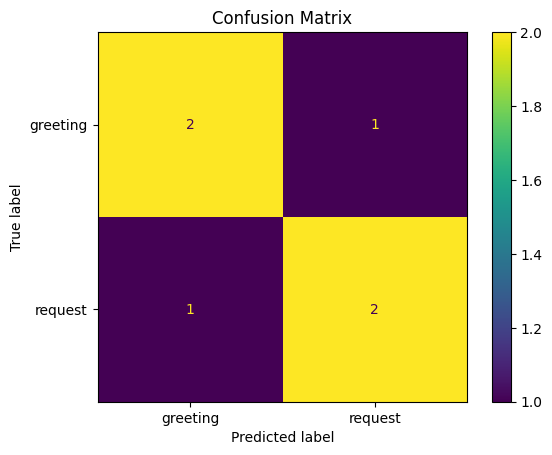

In [86]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have true labels (actual_labels) and predicted labels (predicted_labels)
# You would need to generate these from your ASR or summarization outputs, depending on your task.
# For demonstration purposes, let's create some example data.

# Example for a simple classification task (e.g., intent recognition from ASR transcription)
# Replace with your actual labels if you have them.
# For ASR, a confusion matrix might not be the most suitable metric unless you are
# classifying something based on the transcription.
actual_labels = ["greeting", "greeting", "request", "request", "greeting", "request"]
predicted_labels = ["greeting", "request", "request", "greeting", "greeting", "request"]

# Compute the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Get unique labels for display
labels = sorted(list(set(actual_labels + predicted_labels)))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [85]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Calculate accuracy, precision, and F1-score
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted') # Use weighted for multi-class
f1 = f1_score(actual_labels, predicted_labels, average='weighted') # Use weighted for multi-class

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"F1-score (weighted): {f1:.4f}")

Accuracy: 0.6667
Precision (weighted): 0.6667
F1-score (weighted): 0.6667
